In [9]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt


aerator_data = pd.read_csv(
    "../../../data/processed/aquaculture/aerator_imports/2017-2025_aerator_imports_clean.csv"
)
# Preview the data
print(aerator_data.head())


   importer_ruc probable_importer country_of_origin port_of_loading  \
0  992758791001      karaste_s.a.             china          ningbo   
1  992758791001      karaste_s.a.             china          ningbo   
2  791770270001         aquavi_sa             china          ningbo   
3  791770270001         aquavi_sa             china          ningbo   
4  992653302001      rooster_s.a.            brazil      navegantes   

  transport_mode  packages  quantity   us$_fob  us$_freight  us$_insurance  \
0       maritimo     986.0      34.0   41446.0      2019.18         434.65   
1       maritimo     986.0       1.0     609.5        29.70           6.39   
2       maritimo    2398.0     138.0   40710.0      3023.70         218.67   
3       maritimo    2398.0      68.0   33320.0      2474.81         178.97   
4       maritimo     774.0     110.0  124190.0      3694.13        1274.82   

   ...  us$_fob_unit                                     cargo_agency  \
0  ...        1219.0           

In [10]:
# Create a copy of the original data to preserve it
aerator_data_original = aerator_data.copy()

# Identify categorical columns (excluding date columns)
categorical_columns = aerator_data.select_dtypes(
    include=["object"]
).columns.tolist()

# Remove date columns from categorical columns if they exist
date_columns = [col for col in categorical_columns if "date" in col.lower()]
categorical_columns = [
    col for col in categorical_columns if col not in date_columns
]

print(
    f"Found {len(categorical_columns)} categorical columns: {categorical_columns}"
)

# Since the data is already encoded, let's check if we need to handle any remaining categorical data
if len(categorical_columns) == 0:
    print(
        "Data is already encoded. All categorical columns have been converted to numeric."
    )
    print("\nData is ready for clustering analysis.")
else:
    # Create mappings before converting categorical columns to numeric
    categorical_mappings = {}

    for col in categorical_columns:
        if col in aerator_data.columns:
            unique_values = (
                aerator_data[col].dropna().unique()
            )  # Remove NaN values
            if (
                len(unique_values) > 0
            ):  # Only create mapping if there are unique values
                categorical_mappings[col] = {
                    val: idx for idx, val in enumerate(unique_values)
                }
                print(f"Column '{col}': {len(unique_values)} unique values")
            else:
                print(f"Warning: Column '{col}' has no unique values")
        else:
            print(f"Warning: Column '{col}' not found in dataframe")

    # Convert categorical columns to numeric using the mappings
    for col, mapping in categorical_mappings.items():
        if col in aerator_data.columns:
            aerator_data[col] = aerator_data[col].map(mapping)
            print(f"Converted column '{col}' to numeric")

print(f"\nData shape: {aerator_data.shape}")
print("\nData preview:")
print(aerator_data.head())
print(f"\nData types:\n{aerator_data.dtypes}")


Found 12 categorical columns: ['probable_importer', 'country_of_origin', 'port_of_loading', 'transport_mode', 'consignee_address', 'brand', 'product_model', 'cargo_agency', 'type', 'fuel_type', 'paddlewheels', 'power_hp']
Column 'probable_importer': 61 unique values
Column 'country_of_origin': 8 unique values
Column 'port_of_loading': 21 unique values
Column 'transport_mode': 2 unique values
Column 'consignee_address': 187 unique values
Column 'brand': 22 unique values
Column 'product_model': 45 unique values
Column 'cargo_agency': 50 unique values
Column 'type': 5 unique values
Column 'fuel_type': 4 unique values
Column 'paddlewheels': 6 unique values
Column 'power_hp': 12 unique values
Converted column 'probable_importer' to numeric
Converted column 'country_of_origin' to numeric
Converted column 'port_of_loading' to numeric
Converted column 'transport_mode' to numeric
Converted column 'consignee_address' to numeric
Converted column 'brand' to numeric
Converted column 'product_model'

In [11]:
# Prepare data for clustering
print("Preparing data for clustering analysis...")

# Select features for clustering (excluding IDs and dates)
features_for_clustering = [
    "country_of_origin",
    "port_of_loading",
    "transport_mode",
    "packages",
    "quantity",
    "us$_fob",
    "us$_freight",
    "us$_insurance",
    "us$_cif",
    "net_weight",
    "brand",
    "product_model",
    "type",
    "fuel_type",
    "paddlewheels",
    "power_hp",
    "us$_freight_unit",
    "us$_insurance_unit",
    "us$_cif_unit",
]

# Create clustering dataset
clustering_data = aerator_data[features_for_clustering].copy()

# Check for any remaining missing values
print("Missing values in clustering features:")
print(clustering_data.isnull().sum().sum())

# Scale the features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_data)

print(f"Scaled features shape: {scaled_features.shape}")
print(f"Feature names: {features_for_clustering}")


Preparing data for clustering analysis...
Missing values in clustering features:
0
Scaled features shape: (782, 19)
Feature names: ['country_of_origin', 'port_of_loading', 'transport_mode', 'packages', 'quantity', 'us$_fob', 'us$_freight', 'us$_insurance', 'us$_cif', 'net_weight', 'brand', 'product_model', 'type', 'fuel_type', 'paddlewheels', 'power_hp', 'us$_freight_unit', 'us$_insurance_unit', 'us$_cif_unit']


Finding optimal number of clusters...


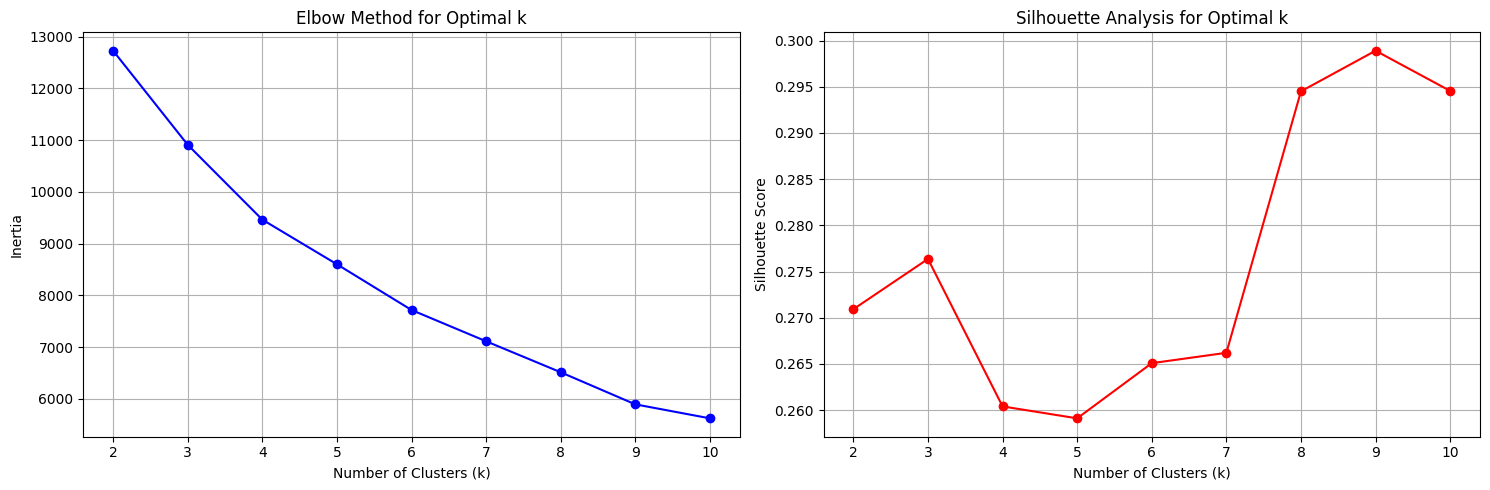

k=2: Silhouette Score = 0.271
k=3: Silhouette Score = 0.276
k=4: Silhouette Score = 0.260
k=5: Silhouette Score = 0.259
k=6: Silhouette Score = 0.265
k=7: Silhouette Score = 0.266
k=8: Silhouette Score = 0.295
k=9: Silhouette Score = 0.299
k=10: Silhouette Score = 0.295


In [12]:
# Determine optimal number of clusters using elbow method
from sklearn.metrics import silhouette_score

print("Finding optimal number of clusters...")

k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(k_range, inertias, "bo-")
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.set_title("Elbow Method for Optimal k")
ax1.grid(True)

# Silhouette scores
ax2.plot(k_range, silhouette_scores, "ro-")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Analysis for Optimal k")
ax2.grid(True)

plt.tight_layout()
plt.show()

# Print silhouette scores
for k, score in zip(k_range, silhouette_scores):
    print(f"k={k}: Silhouette Score = {score:.3f}")


In [13]:
# Perform clustering with optimal k (let's start with k=4 based on typical patterns)
optimal_k = 9
print(f"Performing K-means clustering with k={optimal_k}")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

# Add cluster labels to original data
aerator_data["cluster"] = cluster_labels

# Analyze clusters
print("\nCluster distribution:")
cluster_counts = aerator_data["cluster"].value_counts().sort_index()
print(cluster_counts)
print("\nCluster percentages:")
print((cluster_counts / len(aerator_data) * 100).round(2))


Performing K-means clustering with k=9

Cluster distribution:
cluster
0     50
1    372
2    172
3      1
4      2
5      5
6    123
7      3
8     54
Name: count, dtype: int64

Cluster percentages:
cluster
0     6.39
1    47.57
2    21.99
3     0.13
4     0.26
5     0.64
6    15.73
7     0.38
8     6.91
Name: count, dtype: float64


In [14]:
# Analyze cluster characteristics
print("Cluster Characteristics Analysis")
print("=" * 50)

for cluster_id in sorted(aerator_data["cluster"].unique()):
    cluster_data = aerator_data[aerator_data["cluster"] == cluster_id]
    print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
    print("-" * 30)

    # Key characteristics
    print(f"Average Quantity: {cluster_data['quantity'].mean():.1f}")
    print(f"Average US$ CIF: ${cluster_data['us$_cif'].mean():,.0f}")
    print(f"Average Unit Price: ${cluster_data['us$_cif_unit'].mean():,.0f}")
    print(f"Average Net Weight: {cluster_data['net_weight'].mean():,.0f} kg")

    # Most common categorical features
    print(
        f"Most common country: {aerator_data_original.loc[cluster_data.index, 'country_of_origin'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'country_of_origin'].empty else 'N/A'}"
    )
    print(
        f"Most common brand: {aerator_data_original.loc[cluster_data.index, 'brand'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'brand'].empty else 'N/A'}"
    )
    print(
        f"Most common type: {aerator_data_original.loc[cluster_data.index, 'type'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'type'].empty else 'N/A'}"
    )
    print(
        f"Most common fuel type: {aerator_data_original.loc[cluster_data.index, 'fuel_type'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'fuel_type'].empty else 'N/A'}"
    )
    print(
        f"Most common transport mode: {aerator_data_original.loc[cluster_data.index, 'transport_mode'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'transport_mode'].empty else 'N/A'}"
    )
    print(
        f"Most common port of loading: {aerator_data_original.loc[cluster_data.index, 'port_of_loading'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'port_of_loading'].empty else 'N/A'}"
    )
    print(
        f"Most common product model: {aerator_data_original.loc[cluster_data.index, 'product_model'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'product_model'].empty else 'N/A'}"
    )
    print(
        f"Most common paddlewheels: {aerator_data_original.loc[cluster_data.index, 'paddlewheels'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'paddlewheels'].empty else 'N/A'}"
    )
    print(
        f"Most common power HP: {aerator_data_original.loc[cluster_data.index, 'power_hp'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'power_hp'].empty else 'N/A'}"
    )
    print(
        f"Most common packages: {aerator_data_original.loc[cluster_data.index, 'packages'].mode().iloc[0] if not aerator_data_original.loc[cluster_data.index, 'packages'].empty else 'N/A'}"
    )
    print("=" * 50)


Cluster Characteristics Analysis

Cluster 0 (n=50):
------------------------------
Average Quantity: 147.0
Average US$ CIF: $118,258
Average Unit Price: $1,251
Average Net Weight: 33,799 kg
Most common country: china
Most common brand: generico
Most common type: paddlewheel
Most common fuel type: electric
Most common transport mode: maritimo
Most common port of loading: da_chan_bay
Most common product model: generico
Most common paddlewheels: not_specified
Most common power HP: not_specified
Most common packages: 2340.0

Cluster 1 (n=372):
------------------------------
Average Quantity: 92.9
Average US$ CIF: $59,419
Average Unit Price: $902
Average Net Weight: 13,948 kg
Most common country: china
Most common brand: generico
Most common type: paddlewheel
Most common fuel type: electric
Most common transport mode: maritimo
Most common port of loading: ningbo
Most common product model: generico
Most common paddlewheels: not_specified
Most common power HP: not_specified
Most common packag

Original categorical features: ['country_of_origin', 'port_of_loading', 'transport_mode', 'brand', 'product_model', 'type', 'fuel_type', 'paddlewheels', 'power_hp']
Numerical features: ['packages', 'quantity', 'us$_fob', 'us$_freight', 'us$_insurance', 'us$_cif', 'net_weight', 'us$_freight_unit', 'us$_insurance_unit', 'us$_cif_unit']


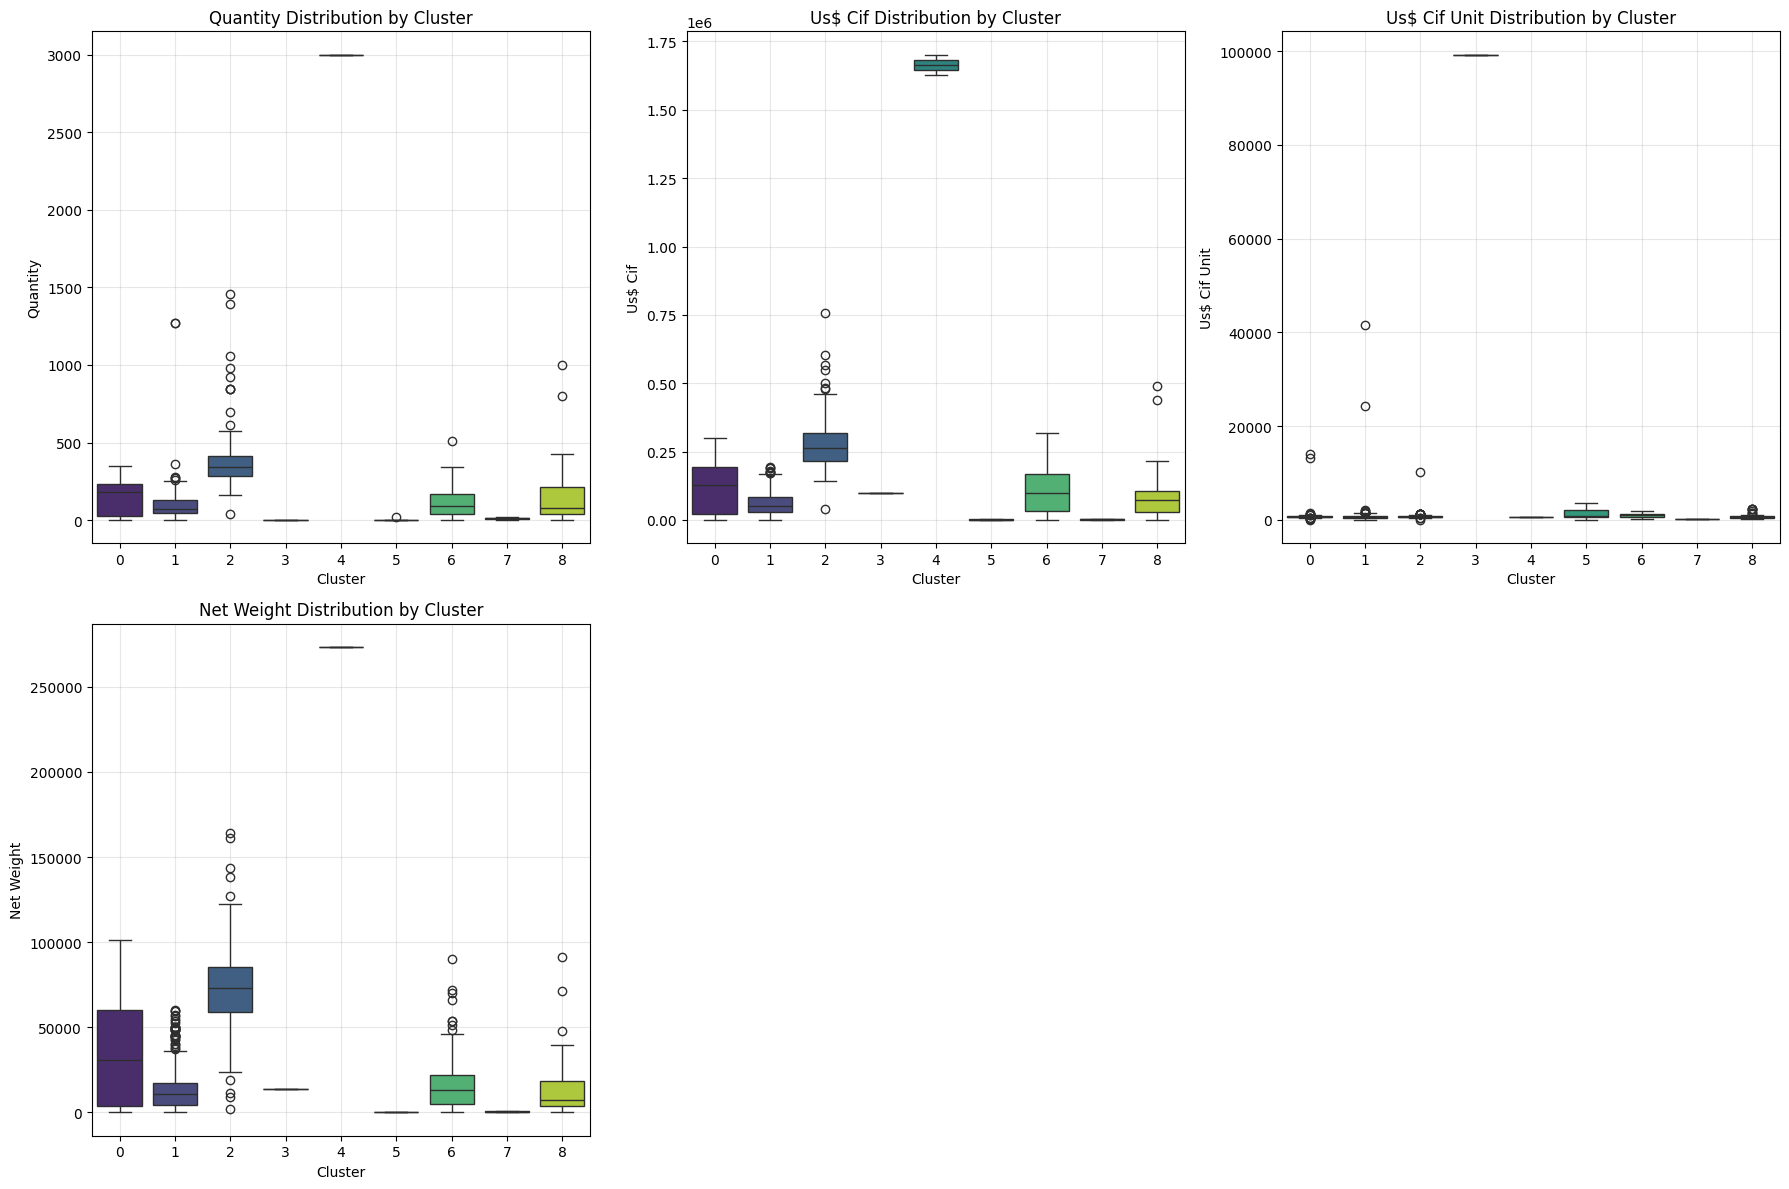


Categorical Features Analysis by Cluster:

Country Of Origin:
----------------------------------------
country_of_origin  brazil  china  germany  india  spain  taiwan  \
cluster                                                           
0                     4.0   52.0      0.0   28.0    0.0     2.0   
1                     1.6   98.4      0.0    0.0    0.0     0.0   
2                     1.2   95.3      0.0    3.5    0.0     0.0   
3                     0.0  100.0      0.0    0.0    0.0     0.0   
4                     0.0  100.0      0.0    0.0    0.0     0.0   
5                     0.0   60.0     20.0    0.0   20.0     0.0   
6                     0.0  100.0      0.0    0.0    0.0     0.0   
7                     0.0  100.0      0.0    0.0    0.0     0.0   
8                    14.8   83.3      0.0    1.9    0.0     0.0   

country_of_origin  united_states  vietnam  
cluster                                    
0                           10.0      4.0  
1                         

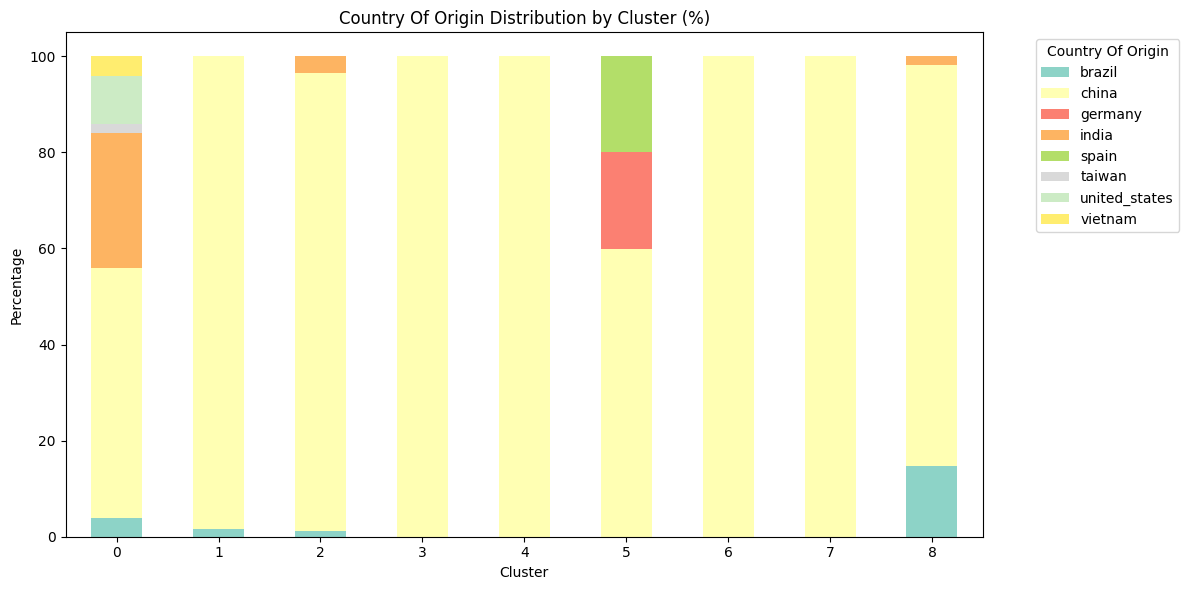


Port Of Loading:
----------------------------------------
port_of_loading  da_chan_bay  haiphong  hamburg  hong_kong  itajai  itapoa  \
cluster                                                                      
0                       46.0       4.0      0.0        0.0     0.0     4.0   
1                        0.0       0.0      0.0        0.0     0.5     0.0   
2                        0.0       0.0      0.0        0.6     0.0     0.0   
3                        0.0       0.0      0.0        0.0     0.0     0.0   
4                        0.0       0.0      0.0        0.0     0.0     0.0   
5                        0.0       0.0     20.0        0.0     0.0     0.0   
6                        0.0       0.0      0.0        0.0     0.0     0.0   
7                        0.0       0.0      0.0        0.0     0.0     0.0   
8                        0.0       0.0      0.0        0.0     0.0    14.8   

port_of_loading  kaohsiung  mobile  mundra  nansha  ...  new_york  ningbo  \
clust

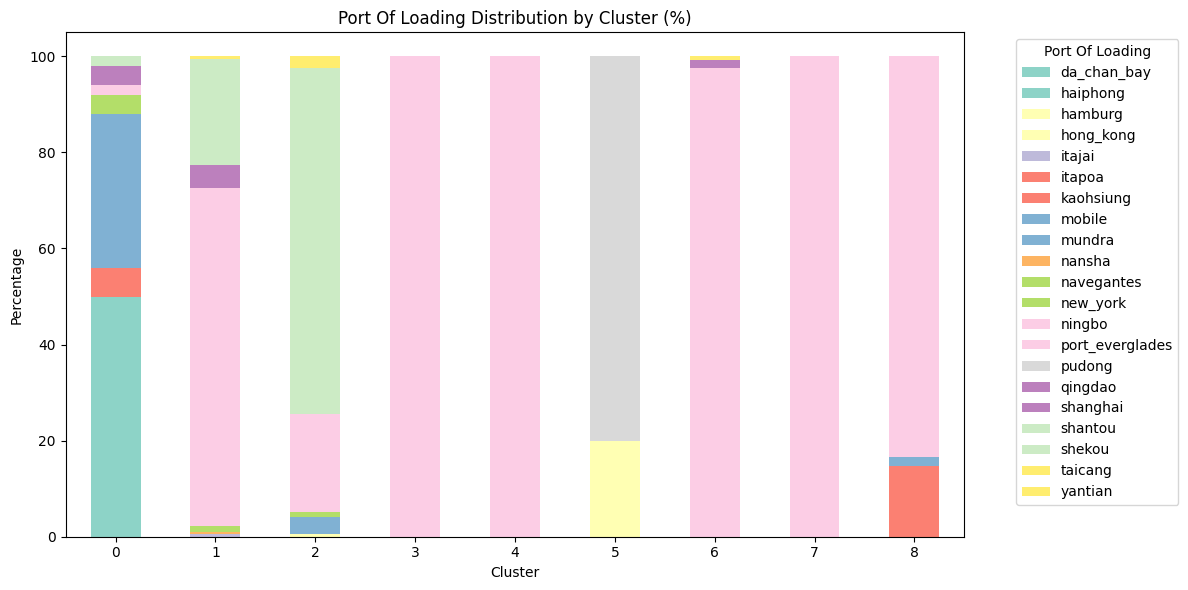


Transport Mode:
----------------------------------------
transport_mode  aerea  maritimo
cluster                        
0                 0.0     100.0
1                 0.0     100.0
2                 0.0     100.0
3                 0.0     100.0
4                 0.0     100.0
5               100.0       0.0
6                 0.0     100.0
7                 0.0     100.0
8                 0.0     100.0


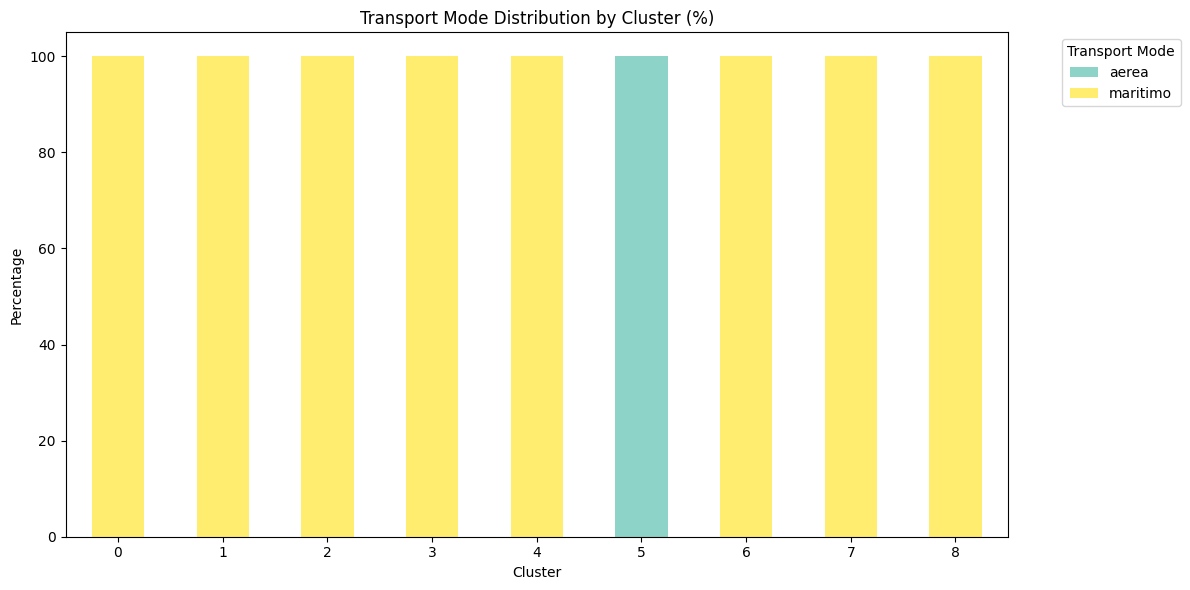


Brand:
----------------------------------------
brand    beraqua  cha_taizhou  diva  gabruce  generico  haikai  \
cluster                                                          
0            4.0          0.0   0.0      0.0      88.0     0.0   
1            1.1          1.9   1.9      0.0      83.3     0.0   
2            1.2          0.0   1.2      0.0      95.9     0.0   
3            0.0          0.0   0.0      0.0     100.0     0.0   
4            0.0          0.0   0.0      0.0     100.0     0.0   
5            0.0          0.0   0.0      0.0      60.0     0.0   
6            0.0          0.0  76.4      7.3       8.1     0.8   
7            0.0          0.0   0.0      0.0     100.0     0.0   
8           14.8          0.0   0.0      0.0      83.3     0.0   

brand    hose_industries  leafy  mashow  nanrong  ...  quingdao  \
cluster                                           ...             
0                    4.0    0.0     0.0      0.0  ...       0.0   
1                    0.

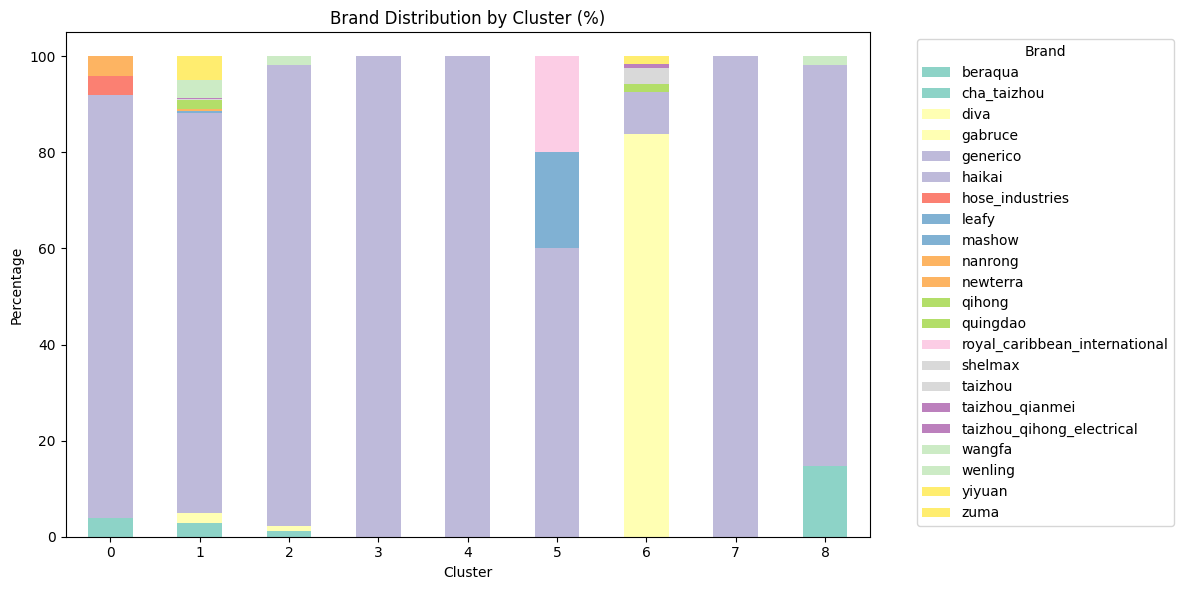


Product Model:
----------------------------------------
product_model  5101380  7c13y  7c16y  b-209  b-601  b-603  b001000014  \
cluster                                                                 
0                  4.0    0.0    0.0    0.0    0.0    0.0         0.0   
1                  0.0    0.0    1.1    0.5    0.3    0.3         0.5   
2                  0.0    1.7    0.6    1.2    0.0    0.0         0.0   
3                  0.0    0.0    0.0    0.0    0.0    0.0         0.0   
4                  0.0    0.0    0.0    0.0    0.0    0.0         0.0   
5                  0.0    0.0    0.0    0.0    0.0    0.0         0.0   
6                  0.0    0.0    0.0    0.0    0.0    0.0         0.0   
7                  0.0    0.0    0.0    0.0    0.0    0.0         0.0   
8                  0.0    0.0    0.0    0.0    0.0    0.0         0.0   

product_model  b002000078  cf1100n  cf110n  ...  yc-12p  yc-16p  yc-2.2  \
cluster                                     ...                 

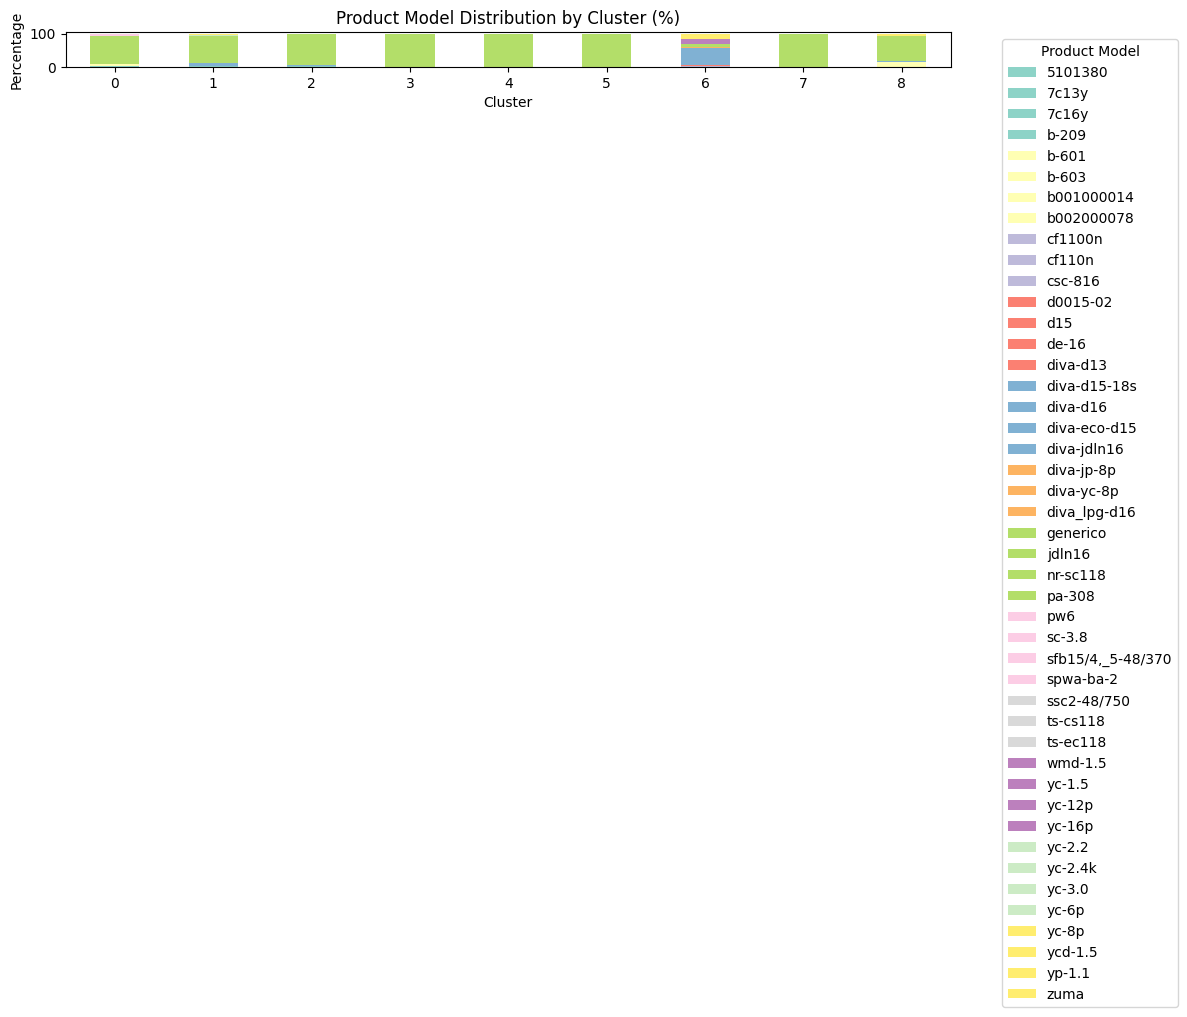


Type:
----------------------------------------
type     air_jet  impeller  paddlewheel  splash  submergible
cluster                                                     
0            0.0       0.0        100.0     0.0          0.0
1            0.0       0.0         99.5     0.0          0.5
2            0.0       0.0        100.0     0.0          0.0
3            0.0       0.0        100.0     0.0          0.0
4            0.0       0.0        100.0     0.0          0.0
5            0.0      40.0         60.0     0.0          0.0
6            0.0       0.0        100.0     0.0          0.0
7           66.7       0.0          0.0    33.3          0.0
8            0.0       0.0        100.0     0.0          0.0


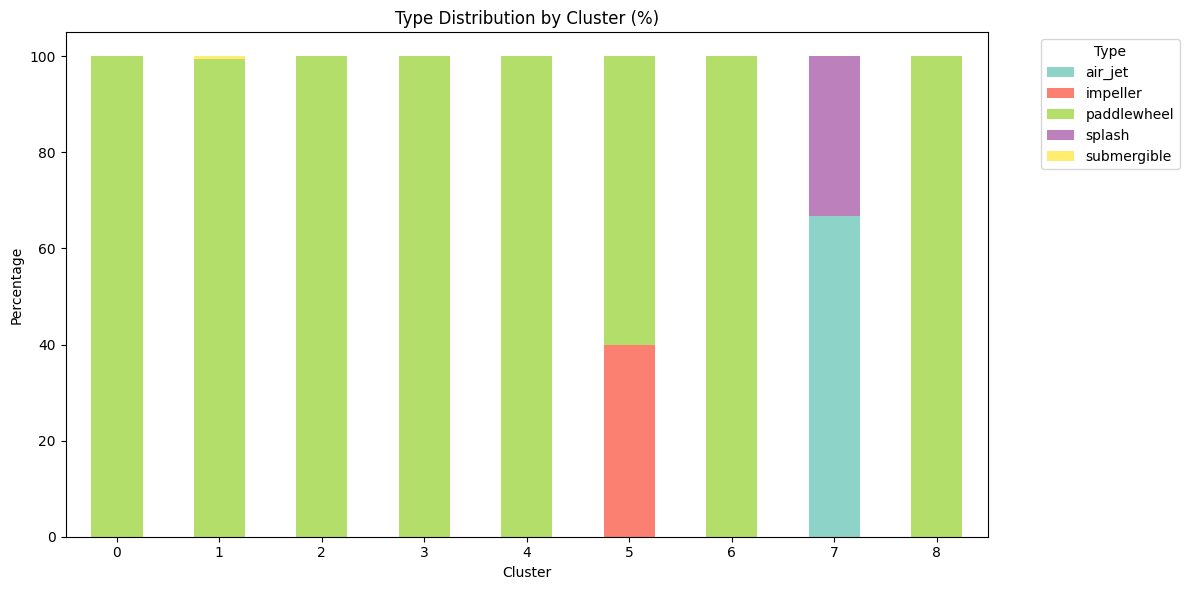

Numerical Feature-Cluster Correlation Analysis:


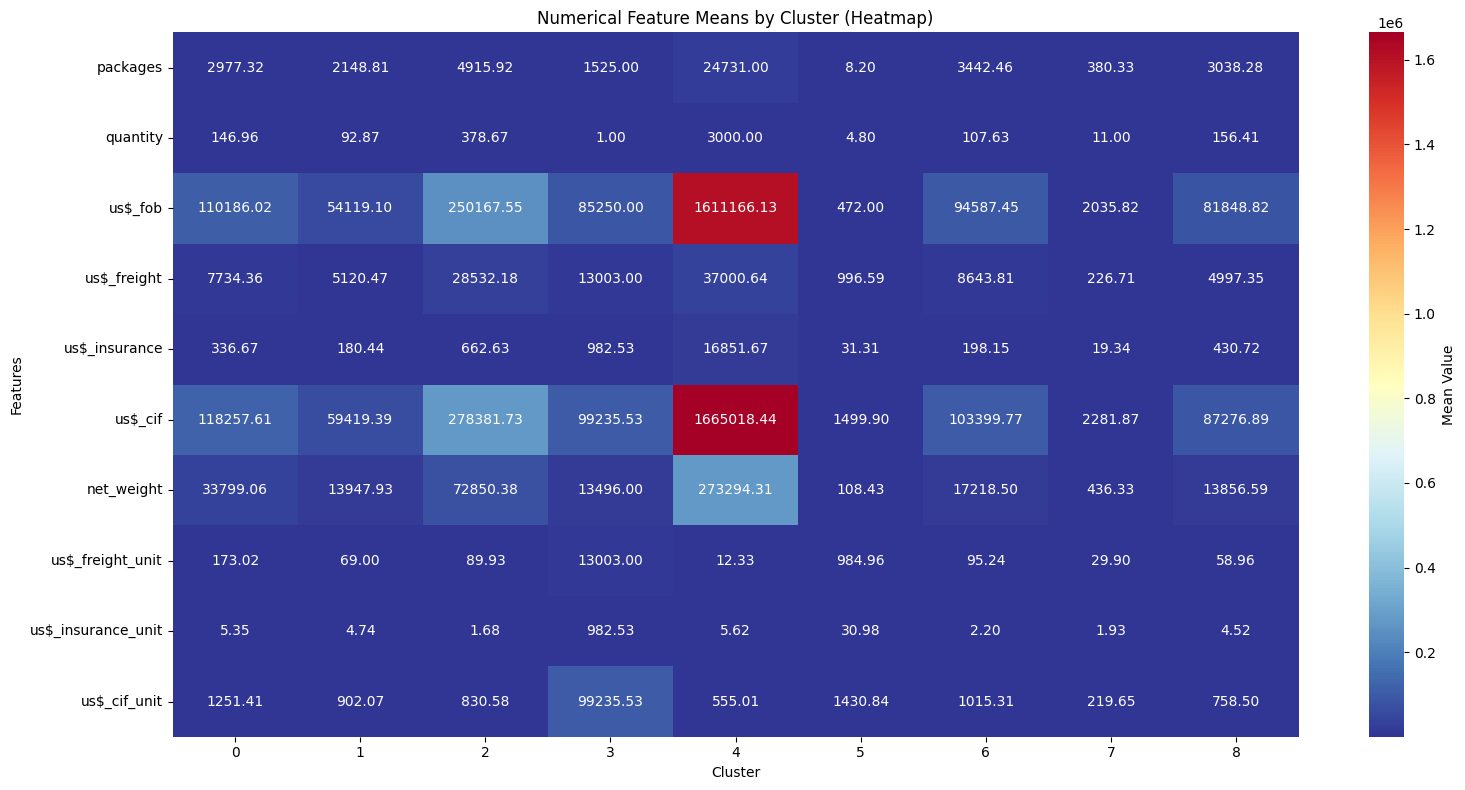

In [15]:
# Create dedicated cluster plots for each feature
import seaborn as sns

plt.style.use("default")

# First, let's identify which features are originally categorical
original_categorical_features = []
numerical_features = []

for feature in features_for_clustering:
    if feature in aerator_data_original.columns:
        if aerator_data_original[feature].dtype == "object":
            original_categorical_features.append(feature)
        else:
            numerical_features.append(feature)

print(f"Original categorical features: {original_categorical_features}")
print(f"Numerical features: {numerical_features}")

# Set up the plotting parameters
n_features = len(features_for_clustering)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

# Create separate detailed plots for key numerical features
key_numerical_features = [
    f
    for f in ["quantity", "us$_cif", "us$_cif_unit", "net_weight", "power_hp"]
    if f in numerical_features
]

if key_numerical_features:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for idx, feature in enumerate(key_numerical_features):
        if idx < len(axes):
            ax = axes[idx]

            # Box plot
            sns.boxplot(
                data=aerator_data,
                x="cluster",
                y=feature,
                ax=ax,
                palette="viridis",
            )

            ax.set_xlabel("Cluster")
            ax.set_ylabel(feature.replace("_", " ").title())
            ax.set_title(
                f"{feature.replace('_', ' ').title()} Distribution by Cluster"
            )
            ax.grid(True, alpha=0.3)

    # Remove unused subplots
    for idx in range(len(key_numerical_features), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

# Create detailed categorical feature analysis
if original_categorical_features:
    print("\nCategorical Features Analysis by Cluster:")
    print("=" * 60)

    for feature in original_categorical_features[
        :6
    ]:  # Show first 6 categorical features
        print(f"\n{feature.replace('_', ' ').title()}:")
        print("-" * 40)

        # Create crosstab
        crosstab = (
            pd.crosstab(
                aerator_data["cluster"],
                aerator_data_original[feature],
                normalize="index",
            )
            * 100
        )

        print(crosstab.round(1))

        # Create visualization
        plt.figure(figsize=(12, 6))
        crosstab.plot(kind="bar", stacked=True, ax=plt.gca(), colormap="Set3")
        plt.title(
            f"{feature.replace('_', ' ').title()} Distribution by Cluster (%)"
        )
        plt.xlabel("Cluster")
        plt.ylabel("Percentage")
        plt.legend(
            title=feature.replace("_", " ").title(),
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

# Create correlation heatmap between numerical features and clusters
numerical_features_only = [
    f for f in features_for_clustering if f in numerical_features
]

if numerical_features_only:
    print("Numerical Feature-Cluster Correlation Analysis:")
    print("=" * 50)

    # Calculate mean values for each cluster (numerical features only)
    cluster_means = aerator_data.groupby("cluster")[
        numerical_features_only
    ].mean()

    # Create heatmap
    plt.figure(figsize=(16, 8))
    sns.heatmap(
        cluster_means.T,
        annot=True,
        fmt=".2f",
        cmap="RdYlBu_r",
        cbar_kws={"label": "Mean Value"},
    )
    plt.title("Numerical Feature Means by Cluster (Heatmap)")
    plt.xlabel("Cluster")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


Model Evaluation and Prediction Analysis
Training set size: 547
Test set size: 235
Price features used as predictors: ['us$_cif', 'us$_cif_unit']
Target numerical features: ['packages', 'quantity', 'us$_fob', 'us$_freight', 'us$_insurance', 'net_weight', 'us$_freight_unit', 'us$_insurance_unit']
Target categorical features: ['country_of_origin', 'port_of_loading', 'transport_mode', 'brand', 'product_model']

1. Predicting Numerical Features from Price
--------------------------------------------------
Packages:
  R² Score: 0.632
  RMSE: 1,822.78
  Feature importance: CIF=0.689, CIF_Unit=0.311
Quantity:
  R² Score: 0.943
  RMSE: 59.48
  Feature importance: CIF=0.754, CIF_Unit=0.246
Us$ Fob:
  R² Score: 0.957
  RMSE: 29,632.20
  Feature importance: CIF=0.995, CIF_Unit=0.005
Us$ Freight:
  R² Score: 0.642
  RMSE: 9,995.63
  Feature importance: CIF=0.630, CIF_Unit=0.370
Us$ Insurance:
  R² Score: 0.861
  RMSE: 481.55
  Feature importance: CIF=0.771, CIF_Unit=0.229
Net Weight:
  R² Score: 0

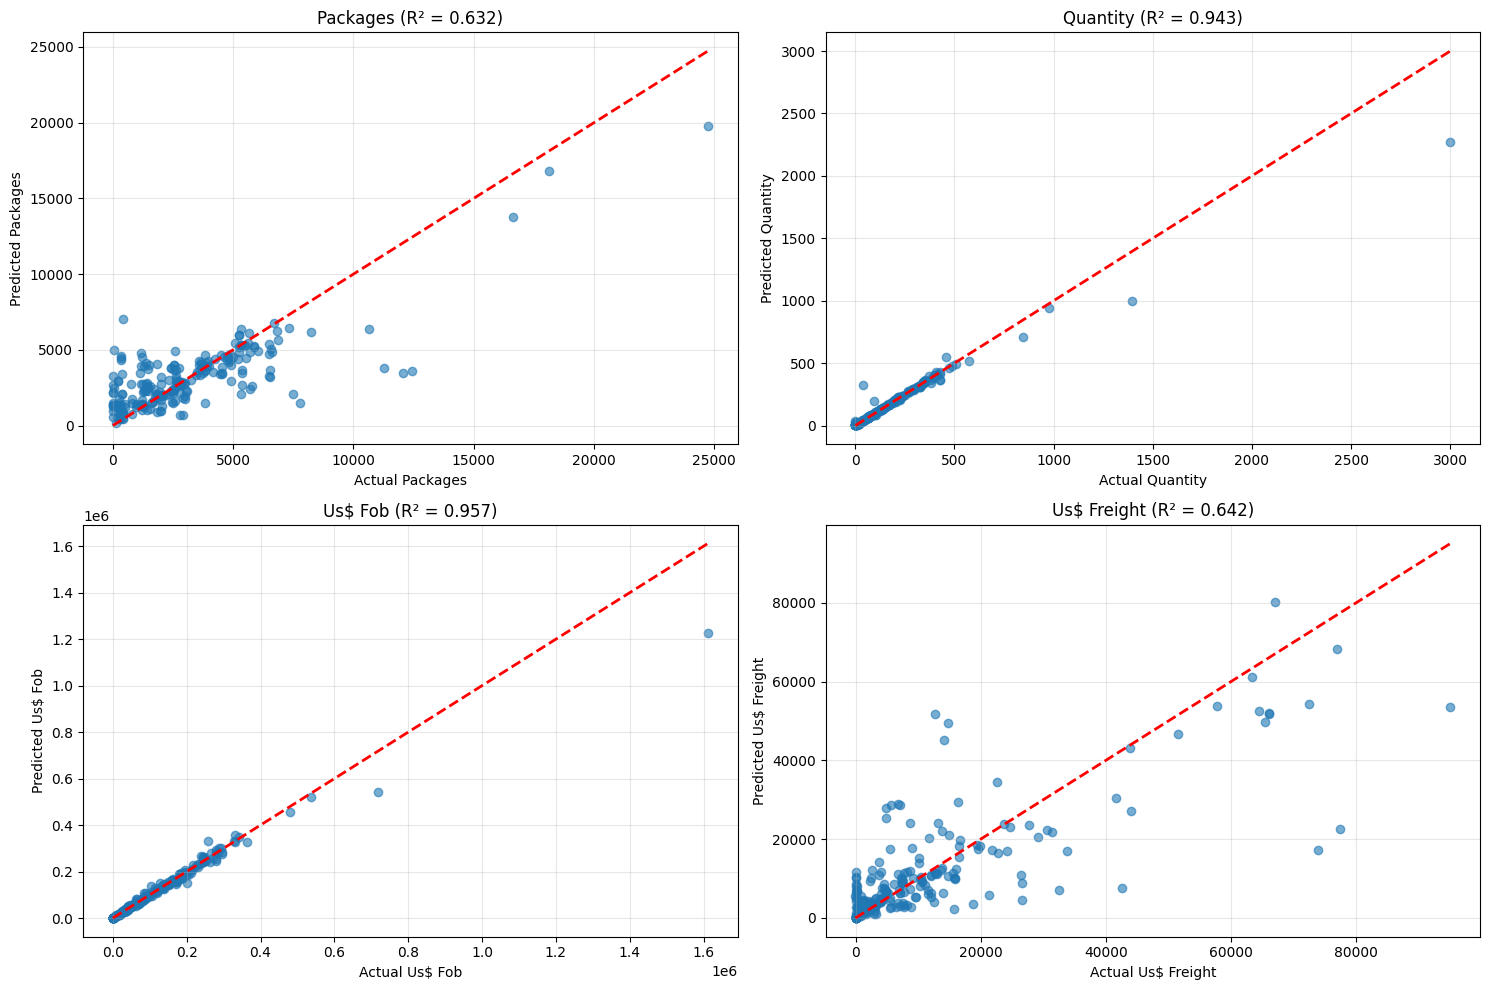


6. Model Diagnostic Summary
--------------------------------------------------
Overall cluster prediction accuracy: 0.723
Best numerical feature prediction: us$_fob (R² = 0.957)
Best categorical feature prediction: transport_mode (Accuracy = 0.991)

7. Recommendations for Model Improvement
--------------------------------------------------
• Consider using ensemble methods or deep learning for better predictions
• Add more features like time series data, market conditions, or technical specifications


In [16]:
# Model Evaluation: Predict features for given prices and evaluate against real data
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    accuracy_score,
)
import warnings

warnings.filterwarnings("ignore")

print("Model Evaluation and Prediction Analysis")
print("=" * 60)

# Prepare data for prediction models
# Use price-related features as predictors
price_features = ["us$_cif", "us$_cif_unit"]
target_features = [f for f in numerical_features if f not in price_features]
categorical_targets = original_categorical_features[
    :5
]  # Limit to first 5 for manageable output

# Split data for training and testing
X = aerator_data[price_features].copy()
X_train, X_test, y_train_idx, y_test_idx = train_test_split(
    X, aerator_data.index, test_size=0.3, random_state=42
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Price features used as predictors: {price_features}")
print(f"Target numerical features: {target_features}")
print(f"Target categorical features: {categorical_targets}")

# 1. Predict numerical features from price
print("\n1. Predicting Numerical Features from Price")
print("-" * 50)

numerical_predictions = {}
numerical_scores = {}

for target in target_features:
    if target in aerator_data.columns:
        y_train = aerator_data.loc[y_train_idx, target]
        y_test = aerator_data.loc[y_test_idx, target]

        # Train Random Forest model
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)

        # Make predictions
        y_pred = rf_model.predict(X_test)

        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        numerical_predictions[target] = {
            "model": rf_model,
            "predictions": y_pred,
            "actual": y_test,
            "mse": mse,
            "r2": r2,
        }

        print(f"{target.replace('_', ' ').title()}:")
        print(f"  R² Score: {r2:.3f}")
        print(f"  RMSE: {np.sqrt(mse):,.2f}")
        print(
            f"  Feature importance: CIF={rf_model.feature_importances_[0]:.3f}, CIF_Unit={rf_model.feature_importances_[1]:.3f}"
        )

# 2. Predict categorical features from price
print("\n2. Predicting Categorical Features from Price")
print("-" * 50)

categorical_predictions = {}

for target in categorical_targets:
    if target in aerator_data_original.columns:
        y_train = aerator_data_original.loc[y_train_idx, target]
        y_test = aerator_data_original.loc[y_test_idx, target]

        # Remove any NaN values
        valid_train_mask = ~y_train.isna()
        valid_test_mask = ~y_test.isna()

        if (
            valid_train_mask.sum() > 10 and valid_test_mask.sum() > 5
        ):  # Ensure enough data
            X_train_valid = X_train[valid_train_mask]
            y_train_valid = y_train[valid_train_mask]
            X_test_valid = X_test[valid_test_mask]
            y_test_valid = y_test[valid_test_mask]

            # Train Random Forest classifier
            rf_classifier = RandomForestClassifier(
                n_estimators=100, random_state=42
            )
            rf_classifier.fit(X_train_valid, y_train_valid)

            # Make predictions
            y_pred = rf_classifier.predict(X_test_valid)

            # Calculate accuracy
            accuracy = accuracy_score(y_test_valid, y_pred)

            categorical_predictions[target] = {
                "model": rf_classifier,
                "predictions": y_pred,
                "actual": y_test_valid,
                "accuracy": accuracy,
            }

            print(f"{target.replace('_', ' ').title()}:")
            print(f"  Accuracy: {accuracy:.3f}")
            print(f"  Unique classes: {len(rf_classifier.classes_)}")

# 3. Predict cluster membership from price
print("\n3. Predicting Cluster Membership from Price")
print("-" * 50)

y_train_cluster = aerator_data.loc[y_train_idx, "cluster"]
y_test_cluster = aerator_data.loc[y_test_idx, "cluster"]

rf_cluster = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cluster.fit(X_train, y_train_cluster)

cluster_pred = rf_cluster.predict(X_test)
cluster_accuracy = accuracy_score(y_test_cluster, cluster_pred)

print(f"Cluster prediction accuracy: {cluster_accuracy:.3f}")
print(
    f"Feature importance: CIF={rf_cluster.feature_importances_[0]:.3f}, CIF_Unit={rf_cluster.feature_importances_[1]:.3f}"
)

# 4. Create prediction examples for specific price ranges
print("\n4. Prediction Examples for Specific Price Ranges")
print("-" * 50)

# Define price scenarios
price_scenarios = [
    {"us$_cif": 500, "us$_cif_unit": 100, "scenario": "Low Price"},
    {"us$_cif": 2000, "us$_cif_unit": 400, "scenario": "Medium Price"},
    {"us$_cif": 5000, "us$_cif_unit": 800, "scenario": "High Price"},
    {"us$_cif": 10000, "us$_cif_unit": 1200, "scenario": "Very High Price"},
]

for scenario in price_scenarios:
    print(
        f"\n{scenario['scenario']} Scenario (CIF: ${scenario['us$_cif']}, Unit: ${scenario['us$_cif_unit']}):"
    )
    print("-" * 30)

    # Create input for prediction
    scenario_input = np.array(
        [[scenario["us$_cif"], scenario["us$_cif_unit"]]]
    )

    # Predict cluster
    predicted_cluster = rf_cluster.predict(scenario_input)[0]
    cluster_proba = rf_cluster.predict_proba(scenario_input)[0]
    print(
        f"Predicted Cluster: {predicted_cluster} (confidence: {cluster_proba[predicted_cluster]:.3f})"
    )

    # Predict numerical features
    for target in target_features[:3]:  # Show first 3 numerical features
        if target in numerical_predictions:
            pred_value = numerical_predictions[target]["model"].predict(
                scenario_input
            )[0]
            print(
                f"Predicted {target.replace('_', ' ').title()}: {pred_value:,.2f}"
            )

    # Predict categorical features
    for target in categorical_targets[:2]:  # Show first 2 categorical features
        if target in categorical_predictions:
            pred_category = categorical_predictions[target]["model"].predict(
                scenario_input
            )[0]
            print(
                f"Predicted {target.replace('_', ' ').title()}: {pred_category}"
            )

# 5. Model Performance Visualization
print("\n5. Model Performance Visualization")
print("-" * 50)

# Plot actual vs predicted for numerical features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (target, results) in enumerate(
    list(numerical_predictions.items())[:4]
):
    if idx < 4:
        ax = axes[idx]

        actual = results["actual"]
        predicted = results["predictions"]

        ax.scatter(actual, predicted, alpha=0.6)
        ax.plot(
            [actual.min(), actual.max()],
            [actual.min(), actual.max()],
            "r--",
            lw=2,
        )
        ax.set_xlabel(f"Actual {target.replace('_', ' ').title()}")
        ax.set_ylabel(f"Predicted {target.replace('_', ' ').title()}")
        ax.set_title(
            f"{target.replace('_', ' ').title()} (R² = {results['r2']:.3f})"
        )
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary
print("\n6. Model Diagnostic Summary")
print("-" * 50)
print(f"Overall cluster prediction accuracy: {cluster_accuracy:.3f}")
print(
    f"Best numerical feature prediction: {max(numerical_predictions.items(), key=lambda x: x[1]['r2'])[0]} (R² = {max(numerical_predictions.values(), key=lambda x: x['r2'])['r2']:.3f})"
)
print(
    f"Best categorical feature prediction: {max(categorical_predictions.items(), key=lambda x: x[1]['accuracy'])[0]} (Accuracy = {max(categorical_predictions.values(), key=lambda x: x['accuracy'])['accuracy']:.3f})"
)

# Recommendations
print("\n7. Recommendations for Model Improvement")
print("-" * 50)
if cluster_accuracy < 0.7:
    print(
        "• Cluster prediction accuracy is low - consider adding more features or adjusting cluster count"
    )
if max(numerical_predictions.values(), key=lambda x: x["r2"])["r2"] < 0.5:
    print(
        "• Numerical feature predictions show weak correlation - price alone may not be sufficient"
    )
if (
    max(categorical_predictions.values(), key=lambda x: x["accuracy"])[
        "accuracy"
    ]
    < 0.6
):
    print(
        "• Categorical feature predictions need improvement - consider feature engineering"
    )
print(
    "• Consider using ensemble methods or deep learning for better predictions"
)
print(
    "• Add more features like time series data, market conditions, or technical specifications"
)
